In [1]:
# https://www.mdpi.com/2076-3417/12/19/10077

In [2]:
import os
# !pwd

from pathlib import Path

dir_path = Path(r"/Users/rabinatwayana/Rabina/CDE II/Wildfire Project/SAR-Burnt-Area-Mapping/")

if dir_path.exists():
    os.chdir(dir_path)
else:
    print("Directory does not exist! Please check the path.")

In [3]:
import geopandas as gpd
import rasterio
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,\
                            precision_score,recall_score,f1_score,roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=UserWarning)
import joblib
import os
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from utils import evaluate_model

### Load sample points and sar data


In [4]:
# #eaton
# sample_feature_path="MachineLearning/output/sample_feature/eaton_sar_indices.csv"
# feature_column_names=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI",'Δvv_vh_ratio',"ΔRDFI","RCBI"]
# extended_file_name="_eaton_sar"
# feature_image_path = "MachineLearning/output/feature_image/eaton_sar_indices.tif"


# # sample_feature_path="MachineLearning/output/sample_feature/eaton_sar_optical_indices.csv"
# # feature_column_names=["dTRAD","dNBR","RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI",'Δvv_vh_ratio',"ΔRDFI","RCBI"]
# # extended_file_name="_eaton_sar_optical"
# # feature_image_path = "MachineLearning/output/feature_image/eaton_sar_optical_indices.tif"


# # # Load SAR GeoTIFF
# drop_columns=['id','class','geometry','Dnbr1','dTRAD1']
# training_data=pd.read_csv(sample_feature_path)

# class_column_name='class'

# output_model_dir="MachineLearning/output/model/"
# output_feat_imp_dir="MachineLearning/output/feature_importance/"
# corr_mat_dir="MachineLearning/output/correlation/"



In [5]:
# #palisades
feature_image_path = "MachineLearning/output/feature_image/palisades_sar_avg_and_desc.tif"
sample_feature_path="MachineLearning/output/sample_feature/palisades_sar_avg_and_desc.csv"
feature_column_names=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI"] #,
extended_file_name="_palisades_sar_avg_and_desc"


# sample_feature_path="MachineLearning/output/sample_feature/palisades_sar_optical_indices.csv"
# feature_column_names=["dTRAD","dNBR","RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI",'Δvv_vh_ratio',"ΔRDFI","RCBI"]
# extended_file_name="_palisades_sar_optical"
# feature_image_path = "MachineLearning/output/feature_image/palisades_sar_optical_indices.tif"


# Load SAR GeoTIFF ,'Dnbr1','id','class',
drop_columns=['geometry','Dnbr1','id','class']
# drop_columns=['x','y','class']
training_data=pd.read_csv(sample_feature_path)

class_column_name='class'

output_model_dir="MachineLearning/output/model/"
output_feat_imp_dir="MachineLearning/output/feature_importance/"
corr_mat_dir="MachineLearning/output/correlation/"


In [6]:
# Count the total number of rows (data points)
total_rows = training_data.shape[0]

# Count the number of unique classes (assuming the class column is named 'class')
unique_classes = training_data[class_column_name].nunique()

# Alternatively, to get a count of each unique class
class_counts = training_data[class_column_name].value_counts()

# Display the results
print(f"Total number of rows: {total_rows}")
print(f"Number of unique classes: {unique_classes}")
print(f"Class distribution:\n{class_counts}")

Total number of rows: 2336
Number of unique classes: 2
Class distribution:
class
0    1230
1    1106
Name: count, dtype: int64


In [7]:
# Specify the number of samples to select for each class
# samples_per_class = 1150  # You can change this number as needed
samples_per_class = training_data[training_data[class_column_name] == 1].shape[0]
# samples_per_class = 1021

# Function to sample a specified number of data points from each class
training_data = training_data.groupby('class').apply(lambda x: x.sample(n=samples_per_class, random_state=42))

# Reset index after applying the groupby operation
training_data = training_data.reset_index(drop=True)



In [8]:
# training_data.columns

# import geopandas as gpd
# from shapely.geometry import Point

# # Create geometry column from x and y
# geometry = [Point(xy) for xy in zip(training_data['x'], training_data['y'])]

# # Convert to GeoDataFrame
# gdf_points = gpd.GeoDataFrame(training_data, geometry=geometry)

# # Set the CRS (assumes same as the raster, e.g., EPSG:32633 or 4326)
# gdf_points.set_crs(epsg=32611, inplace=True)  # Replace with correct EPSG code if needed

# # Save to shapefile
# gdf_points.to_file("temp_training.shp")


In [9]:
dataset = rasterio.open(feature_image_path)
# Get the number of bands
num_bands = dataset.count
print(f"Number of bands: {num_bands}")

Number of bands: 5


In [10]:
# Separate features (SAR bands) and labels (e.g., class column)
X = training_data[feature_column_names]  # Features (SAR band values)
Y = training_data[class_column_name]  # Labels (add 'Class' column in your CSV if available)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)


In [11]:
# from scipy.ndimage import uniform_filter

# def predict(model, image_path, output_file_path ):
#     dataset = rasterio.open(image_path)
#     print(dataset.count)

#     # Read the image bands into an array (assuming it's a multi-band raster)
#     sar_bands = np.stack([dataset.read(i+1) for i in range(dataset.count)], axis=-1)

#     # Reshape the SAR data to a 2D array (num_pixels, num_bands)
#     height, width, num_bands = sar_bands.shape
#     pixels = sar_bands.reshape(-1, num_bands)  # Each row is a pixel
#     print(num_bands,"num_bands")

#     # Preprocess (scale) the pixel values if needed (based on training data preprocessing)
#     # scaler = StandardScaler()
#     # pixels_scaled = scaler.fit_transform(pixels)  # Apply scaling to the pixels

#     # Predict for each pixel
#     predictions = model.predict(pixels)
#     print(np.unique(predictions))

#     # Assuming predictions are a 2D array (for an image or spatial data)
#     predictions = uniform_filter(predictions, size=7)  # size is the window size

#     # predictions = model.predict(scaler.transform(pixels))


#     # Reshape predictions to match the image dimensions
#     predicted_image = predictions.reshape(height, width)

#     # Save the predicted classes to a new file
#     # output_path = f"output/prediction/{prefix}_{model_name}_{extended_file_name}.tif"
#     meta = dataset.meta
#     meta.update(dtype=rasterio.uint8, count=1)  # Assuming class labels are integers, uint8 works for this

#     with rasterio.open(output_file_path, 'w', **meta) as dest:
#         dest.write(predicted_image.astype(rasterio.uint8), 1)  # Write to the first band

#     print(f"Predictions saved to {output_file_path}")

#     pred_dataset = rasterio.open(output_file_path)

#     # Read the first band of the image (you can adjust for multi-band images)
#     pred_band_1 = pred_dataset.read(1)

#     # Plot the image
#     plt.figure(figsize=(10, 10))
#     plt.imshow(pred_band_1, cmap='gray')  # You can adjust the colormap if needed
#     plt.colorbar()
#     plt.title("SAR Burnt Area Prediction Map")
#     plt.show()

from scipy.ndimage import uniform_filter
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def predict(model, image_path, output_file_path, confidence_output_path=None):
    # Open the image
    dataset = rasterio.open(image_path)
    print(dataset.count)

    # Read the image bands into an array (assuming it's a multi-band raster)
    sar_bands = np.stack([dataset.read(i + 1) for i in range(dataset.count)], axis=-1)

    # Reshape the SAR data to a 2D array (num_pixels, num_bands)
    height, width, num_bands = sar_bands.shape
    pixels = sar_bands.reshape(-1, num_bands)  # Each row is a pixel
    print(num_bands, "num_bands")

    # Predict probabilities for each pixel
    predictions_proba = model.predict_proba(pixels)

    # Get the confidence (max probability) for each pixel
    confidence = np.max(predictions_proba, axis=1)  # Max probability for each pixel
    print(f"Confidence range: {np.min(confidence)} to {np.max(confidence)}")

    # Smooth the confidence values using uniform filter
    confidence_smoothed = uniform_filter(confidence, size=7)  # Adjust size for smoothing

    # Reshape predictions and confidence to match image dimensions
    predicted_image = model.predict(pixels).reshape(height, width)
    confidence_map = confidence_smoothed.reshape(height, width)

    # Save the predicted classes to a new file
    meta = dataset.meta
    meta.update(dtype=rasterio.uint8, count=1)  # Assuming class labels are integers, uint8 works for this

    with rasterio.open(output_file_path, 'w', **meta) as dest:
        dest.write(predicted_image.astype(rasterio.uint8), 1)  # Write to the first band

    print(f"Predictions saved to {output_file_path}")

    # Optionally save the confidence map if provided
    if confidence_output_path:
        with rasterio.open(confidence_output_path, 'w', **meta) as dest:
            dest.write(confidence_map.astype(rasterio.float32), 1)  # Confidence as float32 for precision

        print(f"Confidence map saved to {confidence_output_path}")

    # Plot the predicted image
    plt.figure(figsize=(10, 10))
    plt.imshow(predicted_image, cmap='gray')  # You can adjust the colormap if needed
    plt.colorbar()
    plt.title("SAR Burnt Area Prediction Map")
    plt.show()

    # Plot the confidence map
    plt.figure(figsize=(10, 10))
    plt.imshow(confidence_map, cmap='viridis')  # You can adjust the colormap for confidence
    plt.colorbar(label='Confidence Level')
    plt.title("Prediction Confidence Map")
    plt.show()



In [12]:

X_train

,RBD_VV,RBD_VH,RBR_VV,RBR_VH,ΔRVI
1977,0.016713,-0.003017,0.071261,-0.110118,-1.461892
798,0.013241,0.016647,0.056358,0.178179,1.911731
1493,0.111928,0.021572,0.279429,0.355921,1.134564
1364,0.217894,-0.006127,0.159432,-0.206376,-0.582949
903,0.206162,0.021357,0.170417,0.350507,2.413862
...,...,...,...,...,...
1638,-0.016802,-0.002426,-0.039098,-0.030752,0.827049
1095,-0.006255,0.000618,-0.065389,0.017611,0.607039
1130,-0.005005,0.001400,-0.005638,0.013173,0.167994
1294,0.058218,0.011127,0.206525,0.202353,-0.034910


In [13]:

# RF_Model=RandomForestClassifier(n_estimators= 100, min_samples_split= 40, max_features= 3,max_depth= 8,bootstrap=True)
# {'n_estimators': 300, 'min_samples_split': 8, 'max_features': 2, 'max_depth': 10}
RF_Model=RandomForestClassifier(n_estimators= 300, min_samples_split= 40, max_features= 2,max_depth= 10,bootstrap=True)


***************RandomForest*********************
Model performance for Training set
Model performance
- Accuracy: 0.8801582815149802
- F1 Score: 0.8797149971292889
- Precision Score: 0.8864234682721526
- Recall Score: 0.8801582815149802
- Roc Auc Score: 0.880477298292259
--------------
Model performance for Test set
Model performance
- Accuracy: 0.8397291196388262
- F1 Score: 0.8388224770467059
- Precision Score: 0.8452526248480278
- Recall Score: 0.8397291196388262
- Roc Auc Score: 0.8383324497369601
----------------------------------------
Model saved successfully!


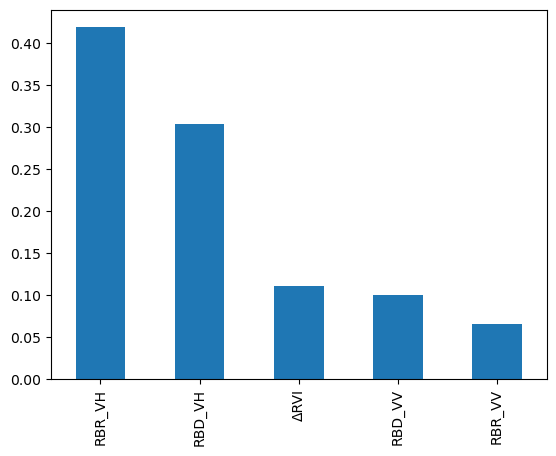

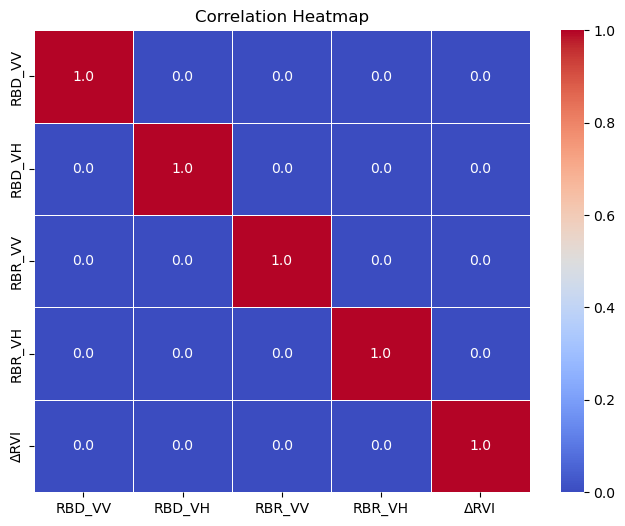

5
5 num_bands
Confidence range: 0.5000002694103095 to 0.9999872286079183
Predictions saved to RandomForest


<Figure size 640x480 with 0 Axes>

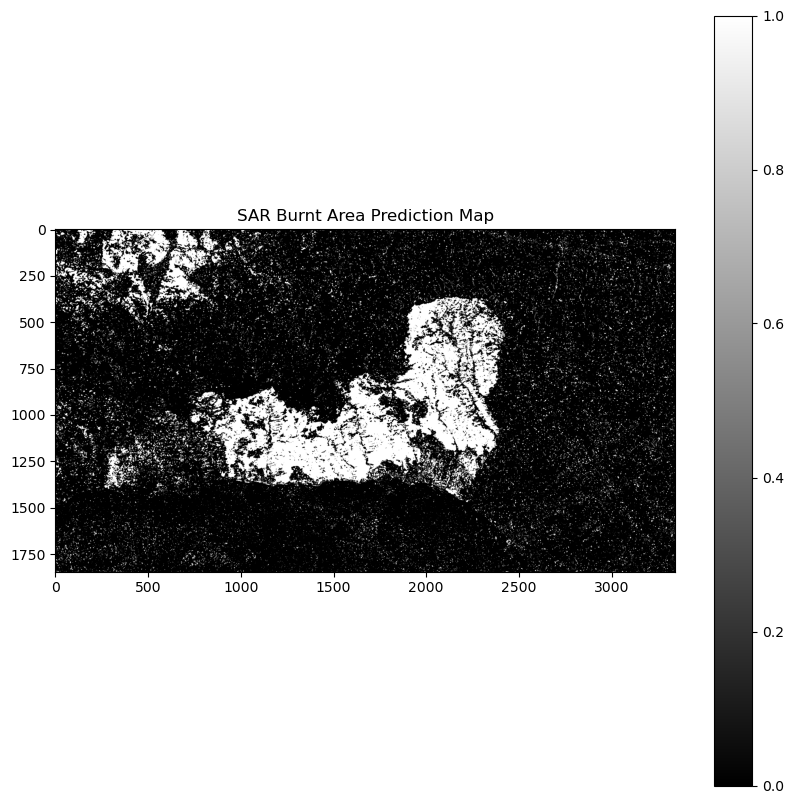

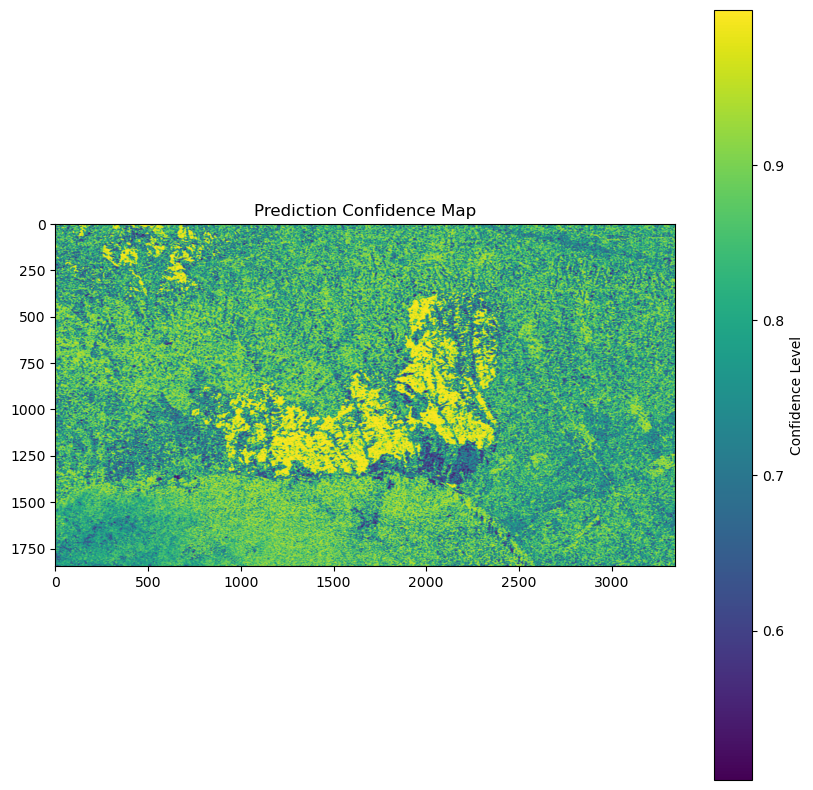

In [14]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

models={
    "RandomForest": RF_Model,
    # "SVM_Model": SVM_Model
    # "RandomForest1": RF_Model_1,
    # "RandomForest2": RF_Model_2,
    # "RandomForest3": RF_Model_3,
    # "RandomForest4": RF_Model_4,
    # "RandomForest5": RF_Model_5,

    # "Decision Tree":DecisionTreeClassifier(),
    # "Logistic Regression":LogisticRegression()
    # "XGBoost": XGB_Model
}


for i in range(len(list(models))):
    model_name=list(models.keys())[i]
    print(f"***************{model_name}*********************")
    model=list(models.values())[i]

    # scaler = StandardScaler()
    # pixels_scaled = scaler.fit_transform(pixels)  # Apply scaling to the pixels
    # X_train=scaler.fit_transform(X_train)
    model.fit(X_train, y_train)
    # print("score",model.score(X_test,y_test))

    #Make a prediction
    y_train_pred=model.predict(X_train)
    # y_test_pred=model.predict(scaler.transform(X_test))
    y_test_pred=model.predict(X_test)

    
    # print(model)
    print('Model performance for Training set')
    evaluate_model(y_train,y_train_pred)

    print("--------------")
    print('Model performance for Test set')
    evaluate_model(y_test,y_test_pred)
    print("----------------------------------------")

    # Assuming you have a trained model called `model`
    joblib.dump(model, f'{output_model_dir}{model_name}{extended_file_name}.pkl')
    print("Model saved successfully!")

     # Plot a simple bar chart
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_importances.plot.bar()
    plt.savefig(f"{output_feat_imp_dir}{model_name}{extended_file_name}.png", dpi=300, bbox_inches="tight")  # Change filename & format as needed

    # print(training_data.columns)
    #export correlation matrix
    training_data_1 = training_data.drop(columns=drop_columns)
    # print(training_data_1.columns)

    # training_data_1 = training_data

    correlation_matrix = training_data_1.corr(method='pearson').round(2)
    correlation_matrix = correlation_matrix.applymap(lambda x: x if x >= 0.7 else 0)
    correlation_matrix.to_csv(f"{corr_mat_dir}{model_name}{extended_file_name}.csv", index=True)

    # Create heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()
    plt.savefig(f"{corr_mat_dir}{model_name}{extended_file_name}.png", dpi=300, bbox_inches="tight")  # PNG format


    # predict(model, feature_image_path,model_name,scaler)
    # predict(model, feature_image_path,model_name)

    predict(model, feature_image_path,model_name)


## plot AUC curve

In [15]:
# ## plot ROC AUC Curve
# plt.figure()
# auc_models = [{
#     'label': 'Random Forest Classifier',
#     'model': RF_Model,
#     'auc':0.73
# }]

# for algo in auc_models:
#     model=algo['model']
#     model.fit(X_train, y_train)
#     fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
#     plt.plot(fpr,tpr,label="Random Forest Classifier ROC (area= 0.71)")

#     plt.plot([0,1],[0,1],'r--')
#     plt.xlim([0.0,1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('1-Specificity (False Positive Rate)')
#     plt.ylabel('Sensitivity (True Positive Rate)')
#     plt.title('Receiver operating characteristics')

#     plt.legend(loc="lower right")

#     plt.savefig("auc.png")
#     plt.show()

#     # Open the TIFF file using rasterio
#     # output_path = "palisades_predictions.tif"  # Replace with your TIFF file path
    
